In [62]:
# EAE 130b - Aircraft Performance and Design
# Assignment 2 - Improved Drag Polar
# Group 9
# 22 April 2025


import numpy as np 
import matplotlib.pyplot as plt

# Reference Area for Each Component

W_0 = 7912 # source - A2 report float(input("Enter the takeoff gross weight (lbs): "))
S_wet_wing = 396 * 2 # check source - Gama & Justin float(input("Enter the reference wing area (ft^2): "))
S_ref_wing = 396
S_wet_fuselage = 572 * 2 # 130B - A1
S_ref_fuselage = 572 
S_ref_ht = 77 # 130B - A1
S_wet_ht = 77 * 2
S_ref_vt = 109 # 130B - A1
S_wet_vt = 109 * 2
#c = 1.0447 # Source - Gama
#d = 0.5326 # Source - Gama
#S_wet = (10 ** c) * (W_0 ** d)# 4605 * 142.45 # float(input("Enter the reference wing wet area (ft^2): "))
mu = 3.737 * (10**-7) # slug/ft-s - dynamic viscoisty of air
chord_wing = 7

def CD_0_calc(V):
    Ma = (V * 1.688) / 1128 # 1128 ft/s is speed of sound
    print(Ma)

    # From OpenVSP
    #Theo_Area   Wet_Area   Theo_Vol    Wet_Vol  Name
    #  430.171    396.135    108.759    106.941  Wing
    #  430.171    396.135    108.759    106.941  Wing
    #   87.687     77.439     14.066     13.264  tail
    #   87.677     77.429     13.850     13.060  tail
    #  124.043    109.413     25.385     23.909  vertical tail
    #  558.291    509.112    667.370    649.826  Fuselage
    #  113.322     63.100     77.589     46.131  cockpit

    # Skin-Friction Coefficient Cf for each component

    FF = 1 # form factor for flat plate - no pressure gradients

    l_fuselage = 40 # length of fuselage
    l_wing = 7 # MAChord
    l_ht = 4.5
    l_vt = 5.5
    #l_engine = 60/12 # Google data for Pt6
    #l_lg = 5 # CHECK

    rho = 0.00238
    #rho_takeoff = 0.00238
    #rho_cruise = 0.0023672
    #rho_landing = 0.00238
    #rho_climb = (rho_cruise + rho_takeoff)/2

    Re_wing = (rho * V * l_wing) / mu
    Re_fuselage = (rho * V * l_fuselage) / mu
    Re_ht = (rho * V * l_ht) / mu
    Re_vt = (rho * V * l_vt) / mu
    #Re_engine = (rho * V * l_engine) / mu
    #Re_lg = (rho * V * l_lg) / mu

    # Laminar flow
    Cf_wing_lam = 1.328 / np.sqrt(Re_wing)
    #Cf_fuselage_lam = 1.328 / np.sqrt(Re_fuselage)
    Cf_ht_lam = 1.328 / np.sqrt(Re_ht)
    Cf_vt_lam = 1.328 / np.sqrt(Re_vt)
    #Cf_engine_lam = 1.328 / np.sqrt(Re_engine)
    #Cf_landing_gear_lam = 1.328 / np.sqrt(Re_lg)

    # Turbulent flow 
    Cf_wing_tur = 0.455 / (((np.log10(Re_wing))**2.58) * ((1 + (0.144 * (Ma**2)))**0.65))
    Cf_fuselage_tur = 0.455 / (((np.log10(Re_fuselage))**2.58) * ((1 + (0.144 * (Ma**2)))**0.65))
    Cf_ht_tur = 0.455 / (((np.log10(Re_ht))**2.58) * ((1 + (0.144 * (Ma**2)))**0.65))
    Cf_vt_tur = 0.455 / (((np.log10(Re_vt))**2.58) * ((1 + (0.144 * (Ma**2)))**0.65))
    #Cf_engine_tur = 0.455 / (((np.log10(Re_engine))**2.58) * ((1 + (0.144 * (Ma**2)))**0.65))
    #Cf_landing_gear_tur = 0.455 / (((np.log10(Re_lg))**2.58) * ((1 + (0.144 * (Ma**2)))**0.65))

    # Weighted average Cf - for gen aviation with classic production metal 
    # - laminar flow estiamtion guidelines (Raymer CH12 - LecB03 slide 13),
    #  0% Fuselage and 10% for wings and tails

    chord_wing = 7
    Cf_wing = (0.1*Cf_wing_lam) + (0.9*Cf_wing_tur)
    Cf_fuselage = Cf_fuselage_tur
    Cf_ht = (0.1*Cf_ht_lam) + (0.9*Cf_ht_tur)
    Cf_vt = (0.1*Cf_vt_lam) + (0.9*Cf_vt_tur)
    #Cf_engine = Cf_engine_tur
    #Cf_landing_gear = (0.1*Cf_landing_gear_lam) + (0.9*Cf_landing_gear_tur)

    #print(Cf_wing)
    #print(Cf_fuselage)
    #print(Cf_ht)

    # Friction Drag: Form Factors
    xc_max = 0.3 * chord_wing # chordwise location of max thickness - NACA 0012 airfoil
    # Max thickness 12% at 30% chord
    tc = 0.12 # max thickness of airfoil 0012 = 0.12
    sweep_wing = np.deg2rad(2)
    sweep_ht = 0
    sweep_vt = np.deg2rad(20)

    # wing
    term1 = 1 + ((0.6 / xc_max) * tc) + (100 * (tc**4))
    term2 = 1.34 * (Ma**0.18) * ((np.cos(sweep_wing))**0.28)
    FF_wing = term1 * term2
    #print(FF_wing)

    # ht
    term3 = 1 + ((0.6 / xc_max) * tc) + (100 * (tc**4))
    term4 = 1.34 * (Ma**0.18) * ((np.cos(sweep_ht))**0.28)
    FF_ht = term3 * term4
    #print(FF_ht)

    # vt 
    term5 = 1 + ((0.6 / xc_max) * tc) + (100 * (tc**4))
    term6 = 1.34 * (Ma**0.18) * ((np.cos(sweep_vt))**0.28)
    FF_vt = term5 * term6

    # fuselage
    f = l_fuselage / (np.sqrt((4/np.pi) * S_ref_fuselage)) # fineness ratio - lecB02 - slide 14
    #print(f) # since f = 1.48 < 6, FF is the following

    FF_fuselage = (0.9 + (5/(f**1.5)) + (f/400))
    #print(FF_fuselage)

    # Interference factor

    Q_wing = 1.2 # unfilleted low wing - LecB03 Slide 15
    Q_fuselage = 1 
    #Q_vt = 1.03
    #Q_ht = 1.08
    Q_tail = 1.05 # for conventional tail
    Q_vt = Q_tail
    Q_ht = Q_tail

    # Miscellaneous Form of Drag

    # Speed brakes, spoilers, bluff surfaces
    u = np.deg2rad(11.4) # longitudinal ground clearance angle
    A_max = (1.63*12 * 2) + (2.1 * 16 * 2) + (2 * 1 * 5) # guess for surface area of flaps
    Dq_brakes = 3.83 * (u ** 2.5) * A_max

    # Fuselage upsweep (subsonic)
    Dq_fuselage = S_ref_fuselage * (0.139 + 0.419 * ((Ma - 0.161)**2))
    #print(Dq_fuselage)

    # Feathered props - when engine fails

    N_blades = 5
    A_blade = 0.5 * 4 # ft^2 - need to check value
    A_blades = N_blades * A_blade
    A_disk = np.pi * (4 ** 2)
    sigma = A_blades / A_disk # is propeller solidity, i.e. total blade area divided by disk area
    Dq_prop = 0.1 * sigma * A_disk
    #print(Dq_prop)

    #Landing gear drag 
    Dq_lg = (0.25 + 0.15 + 0.3) * 2 # check

    drag_area_sum = Dq_brakes + Dq_fuselage + Dq_lg + Dq_prop

    CD_mis = (1/S_ref_wing) * drag_area_sum
    #print("mis" + str(CD_mis))

    # Component Build-up for parasite drag coeff

    comp_wing = Cf_wing * FF_wing * Q_wing * S_wet_wing
    comp_fuselage = Cf_fuselage * FF_fuselage * Q_fuselage * S_wet_fuselage
    comp_ht = Cf_ht * FF_ht * Q_ht * S_wet_ht
    comp_vt = Cf_vt * FF_vt * Q_vt * S_wet_vt

    #print("wing comp" + str(comp_wing))
    #print("fus comp" + str(comp_fuselage))
    #print("ht comp" + str(comp_ht))
    #print("vt comp" + str(comp_vt))

    sum_components = comp_wing + comp_fuselage + comp_ht + comp_vt

    CD_0 = (1/S_ref_wing) * (sum_components) + CD_mis


    # Leakage and Protuberance Drag
    CD_leak = 0.06 * CD_0 # estimated as a percent of total parasite drag 5-10% for prop

    # 4 CD0s for each configuration 
    CD_0 = CD_0 + CD_leak
    return CD_0

In [63]:

V_stall = 52 * 1.688 # 88
V_takeoff = V_stall * 1.1 #
CD_0_takeoff = CD_0_calc(V_takeoff)

V_cruise = 250 * 1.688 * 0.5 # 200
CD_0_cruise = CD_0_calc(V_cruise)

V_landing = V_cruise * 0.85 #
CD_0_landing = CD_0_calc(V_landing)
print(CD_0_cruise) # 0.0193 in previous 130A - A3 code
print(CD_0_takeoff)
print(CD_0_landing)

print(V_takeoff)
print(V_cruise)
print(V_landing)


0.14448801134751774
0.3157517730496454
0.2683890070921986
0.29307390009120804
0.28129390356392
0.2858042841176562
96.5536
211.0
179.35


In [64]:
chord_flap = 2 #0.25 * chord_wing # check
S_ref_flap = 49 # 14 * 2 # 0.25 * S_ref_wing # check
del_flap_takeoff = np.deg2rad(20) #delfection angle of flaps
del_flap_landing = np.deg2rad(60)
#del_flap_cruise = np.deg2rad(15) # CHECK

delta_cD0_landing_flaps_takeoff = 1.7 * ((chord_flap / chord_wing)**1.38) * (S_ref_flap / S_ref_wing) * ((np.sin(del_flap_takeoff))**2)# for plain flap

delta_cD0_landing_flaps_landing = 1.7 * ((chord_flap / chord_wing)**1.38) * (S_ref_flap / S_ref_wing) * ((np.sin(del_flap_landing))**2)# for plain flap

#delta_cD0_landing_flaps_cruise = 1.7 * ((chord_flap / chord_wing)**1.38) * (S_ref_flap / S_ref_wing) * ((np.sin(del_flap_cruise))**2)# for plain flap

print(delta_cD0_landing_flaps_takeoff)
print(delta_cD0_landing_flaps_landing)
#print(delta_cD0_landing_flaps_cruise)


0.00436756405976684
0.02800252397074691


In [65]:
# Takeoff Ma = 0.144
# AoA = -4 deg --> CDi = 0.0116375 CDt = -0.001337 CL =  -0.32787
# AoA = -2 deg --> CDi = 0.0019342  CDt = -0.000562 CL = -0.10570
# AoA = 0 deg --> CDi = 0.0007505 CDt = 0.000205 CL = 0.11708
# AoA = 2 deg --> CDi = 0.0079115 CDt = 0.000961 CL = 0.33928
# AoA = 4 deg --> CDi = 0.0231344 CDt = 0.001701 CL = 0.55976
# AoA = 6 deg --> CDi = 0.0460308 CDt = 0.002422 CL = 0.77743
# AoA = 8 deg --> CDi = 0.0761122 CDt = 0.003120 CL = 0.99124
# AoA = 10 deg --> CDi = 0.1127947 CDt = 0.003791 CL = 1.20021
# AoA = 12 deg --> CDi = 0.1554067 CDt = 0.004431 CL = 1.40343
# AoA = 14 deg --> CDi = 0.2031960 CDt = 0.005038 CL = 1.60008
# AoA = 16 deg --> CDi = 0.2553389 CDt = 0.005607 CL = 1.78944
# AoA = 18 deg --> CDi = 0.3109495 CDt = 0.006135 CL = 1.97089
# AoA = 20 deg --> CDi = 0.3690903 CDt = 0.006620 CL = 2.14390
# AoA = 22 deg --> CDi = 0.4287828 CDt = 0.007059 CL = 2.30808

# AoA going from -10 to 30 deg

CDi_takeoff = [0.0352729, 0.0215667, 0.0119104, 0.0064438, 0.0052558, 0.0083832, 0.0158103, 0.0274691, 0.0432398,
               0.0629527, 0.0863892, 0.1132848, 0.1433319, 0.1761832, 0.2114551, 
               0.2487326, 0.2875735, 0.3275133, 0.3680704, 0.4087514, 0.4490567]
#CDi_takeoff = [0.0116375, 0.0019342, 0.0007505, 0.0079115, 0.0231344, 0.0460308,
 #              0.0761122, 0.1127947, 0.1554067, 0.2031960, 0.2553389, 0.3109495,
 #              0.3690903, 0.4287828]

CDt_takeoff = [-0.000020, 0.000101, 0.000224, 0.000348, 0.000472, 0.000596, 0.000718, 0.000838, 0.000957, 0.001072,
               0.001184, 0.001291, 0.001395, 0.001492, 0.001585, 0.001671, 0.001750, 0.001823, 
               0.001888, 0.001946, 0.001995]
#CDt_takeoff = [-0.001337, -0.000562, 0.000205, 0.000961, 0.001701, 0.002422, 
  #             0.003120, 0.003791, 0.004431, 0.005038, 0.005607, 0.006135, 
  #             0.006620, 0.007059]

CL_takeoff = [-0.40581, -0.28860, -0.16943, -0.04888, 0.07244, 0.19394, 0.31503, 0.43509, 0.55355, 0.66983, 0.78339,
              0.89369, 1.00026, 1.10264, 1.20041, 1.29319, 1.38066, 1.46256, 1.53865, 
              1.60877, 1.67280]
#CL_takeoff = [-0.32787, -0.10570, 0.11708, 0.33928, 0.55976, 0.77743, 0.99124, 
    #          1.20021, 1.40343, 1.60008, 1.78944, 1.97089, 2.14390, 2.30808]

# Cruise Ma = 0.316
CDi_cruise = [0.0356115, 0.0217583, 0.0120163, 0.0065287, 0.0053865, 0.0086280, 0.0162379, 0.0281480, 0.0442375,
              0.0643344, 0.0882175, 0.1156187, 0.1462259, 0.1796866, 0.2156118, 
              0.2535799, 0.2931418, 0.3338258, 0.3751424, 0.4165904, 0.4576618]
#CDi_cruise = [0.0065287, 0.0019490, 0.0007578, 0.0079849, 0.0233477, 0.0464579,
 #             0.0768251, 0.1138635, 0.1568981, 0.2051723, 0.2578573, 0.3140610, 
 #             0.3728390, 0.4332053]

CDt_cruise = [-0.000039, 0.000090, 0.000221, 0.000353, 0.000484, 0.000615, 0.000745, 0.000873, 0.000998, 0.001120,
              0.001238, 0.001352, 0.001461, 0.001564, 0.001661, 0.001752, 0.001836, 0.001912, 
              0.001981, 0.002041, 0.002093]
#CDt_cruise = [0.000353, -0.000565, 0.000207, 0.000967, 0.001713, 0.002439, 
 #             0.003142, 0.003817, 0.004463, 0.005074, 0.005647, 0.006181, 
   #           0.006670, 0.007113]

CL_cruise = [-0.40849, -0.29022, -0.16997, -0.04833, 0.07409, 0.19669, 0.31885, 0.43998, 0.55947, 0.67675, 
             0.79126, 0.90247, 1.00988, 1.11303, 1.21149, 1.30489, 1.39291, 1.47525, 
             1.55169, 1.62206, 1.68625]
#CL_cruise = [-0.04833, -0.10618, 0.11772, 0.34105, 0.56265, 0.78143, 0.99632, 
 #            1.20634, 1.41056, 1.60817, 1.79843, 1.98071, 2.15449, 2.31936]


# Landing Ma = 0.268
CDi_landing = [0.0354894, 0.0216892, 0.0119780, 0.0064978, 0.0053388, 0.0085387, 0.0160822, 0.0279009, 0.0438747,
               0.0638322, 0.0875531, 0.1147708, 0.1451747, 0.1784141, 0.2141021,
               0.2518194, 0.2911195, 0.3315332, 0.3725740, 0.4137433, 0.4545363]
#CDi_landing = [0.0116934, 0.0019430, 0.0007548, 0.0079552, 0.0232613, 0.0462849,
  #             0.0765363, 0.1134306, 0.1562939, 0.2043717, 0.2568370, 0.3128004, 
  #             0.3713201, 0.4314132]
  
CDt_landing = [-0.000032, 0.000094, 0.000222, 0.000351, 0.000480, 0.000608, 0.000735, 0.000860, 0.000983, 0.001102,
               0.001218, 0.001330, 0.001437, 0.001538, 0.001633, 0.001722, 0.001805, 0.001880, 
               0.001947, 0.002006, 0.002057]
#CDt_landing = [-0.001342, -0.000564, 0.000206, 0.000965, 0.001708, 0.002432, 
 #              0.003133, 0.003807, 0.004450, 0.005059, 0.005631, 0.006162, 
  #             0.006650, 0.007091]

CL_landing = [-0.40752, -0.28964, -0.16978, -0.04853, 0.07349, 0.19569, 0.31747, 0.43821, 0.55733, 0.67425, 
              0.78842, 0.89930, 1.00641, 1.10928, 1.20749, 1.30067, 1.38849, 1.47067, 1.54699, 
              1.61727, 1.68140]
#CL_landing = [-0.32882, -0.10598, 0.11746, 0.34033, 0.56148, 0.77981, 0.99426, 
 #             1.20386, 1.40768, 1.60490, 1.79480, 1.97674, 2.15020, 2.31480]

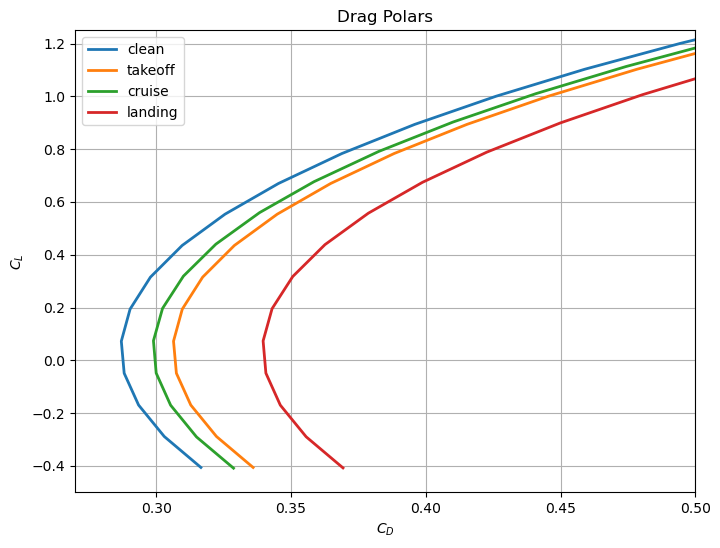

In [66]:
# DRAG POLAR
# From Metabook pg. 35
# From Figure 3.6 of Raymer's text, wetted area to reference wing area has been estimated to be 4 (Cessna Skyline RG)

#S_wet_S_ref =  S_wet / S_ref_wing # 4 - from Raymer's text
#c_f = 0.0055 # figure 4.4 on Metabook - "light aircraft - single engine"
delta_cD0_landing_gear = 0.02 # Raymer's text # ASK
delta_cD0_takeoff = 0.015 # ASK

CD_clean = np.zeros(21)

for i in range(len(CL_takeoff)):
    CD_clean[i] = CD_0_takeoff + CDi_takeoff[i] + CDt_takeoff[i]

CD_takeoff = np.zeros(21)

for i in range(len(CL_takeoff)):
    CD_takeoff[i] = CD_0_takeoff + delta_cD0_landing_flaps_takeoff + CDi_takeoff[i] + CDt_takeoff[i] + delta_cD0_takeoff

CD_cruise = np.zeros(21)

for i in range(len(CL_cruise)):
    CD_cruise[i] = CD_0_cruise + CDi_cruise[i] + CDt_cruise[i] #+ delta_cD0_landing_flaps_cruise # CHECK

CD_landing = np.zeros(21)

for i in range(len(CL_landing)):
    CD_landing[i] = CD_0_landing + delta_cD0_landing_flaps_landing + CDi_landing[i] + CDt_landing[i] + delta_cD0_landing_gear

plt.figure(figsize=(8,6))
plt.title('Drag Polars')
plt.xlabel("$C_D$")
plt.ylabel("$C_L$")
plt.plot(CD_clean, CL_takeoff, label='clean', linestyle='-', linewidth=2)
plt.plot(CD_takeoff, CL_takeoff, label='takeoff', linestyle='-', linewidth=2)
plt.plot(CD_cruise, CL_cruise, label='cruise', linestyle='-', linewidth=2)
plt.plot(CD_landing, CL_landing, label='landing', linestyle='-', linewidth=2)
plt.xlim(0.27, 0.5)
plt.ylim(-0.5, 1.25)
plt.legend(loc='best')
plt.grid(True)
plt.show()
